# raw quote

In [49]:
from datetime import datetime as dt
def download_raw_quotes(year, month, show_process=False):
#---Importing packagesfrom datetime import datetime as dt
    from datetime import timedelta
    import gzip
    import glob
    import os
    import shutil
    import sys
    import time
    import requests
    import pandas as pd
    import numpy as np
    from math import log,sqrt
    import gc
    
    
    try:
        os.makedirs('D://Trading/Data/Crypto/Bitmex/raw_quotes/')
    except:
        pass
    
    def get_next_month_dt(date):
        month = date.month
        year = date.year
        next_month = month % 12 + 1
        next_year = year + month // 12
        return dt(next_year, next_month, date.day)
    

#---Importing raw data of trade and quote
    # https://public.bitmex.com/?prefix=data/trade/
    endpoint = 'https://s3-eu-west-1.amazonaws.com/public.bitmex.com/data/{}/{}.csv.gz'
    def scrape(date,trqu):
        end_date = get_next_month_dt(date)
        while date < end_date:
            date_str = date.strftime('%Y%m%d')
            if show_process:
                print("Processing {} order {}...".format(trqu,date))
            count = 0
            while True:
                r = requests.get(endpoint.format(trqu,date_str))
                if r.status_code == 200:
                    break
                else:
                    count += 1
                    if count == 10:
                        r.raise_for_status()
                    print("Error processing {} - {}, trying again".format(date, r.status_code))
                    time.sleep(10)
            with open(date_str, 'wb') as fp:
                fp.write(r.content)
            with gzip.open(date_str, 'rb') as fp:
                data = fp.read()
            with open(date_str, 'wb') as fp:
                fp.write(data)
            date += timedelta(days=1)
    def merge(date,trqu):
        print("{} - Generating CSV for {} order {} {}".format(dt.now(),trqu,date.month,date.year))
        files = sorted(glob.glob("{}*".format(date.strftime('%Y%m'))))
        with open("D://Trading/Data/Crypto/Bitmex/raw_quotes/{}-{}.csv".format(date.year,date.month), 'wb') as out:
            first = True
            for f in files:
                with open(f, 'rb') as fp:
                    if first:
                        fp.readline()
                        first = False
                    shutil.copyfileobj(fp, out)
        for f in files:
            os.unlink(f)
    if __name__ == '__main__':     
        start = dt(year, month, 1)
        trqu = 'quote'
        scrape(start,trqu)
        merge(start,trqu)
        
def extract_quote_symbol(symbol, year, month):
    list_symbols = ['ADAM19', 'BCHM19', 'EOSM19', 'ETHM19', 'ETHUSD', 'LTCM19',
                    'TRXM19', 'XBT7D_D95', 'XBT7D_U105', 'XBTM19', 'XBTU19', 'XBTUSD',
                    'XRPM19']
    from datetime import timedelta
    import gzip
    import glob
    import os
    import shutil
    import sys
    import time
    import requests
    import pandas as pd
    import numpy as np
    from math import log,sqrt
    import gc
    import datetime
    date = datetime.datetime(year, month, 1)
    
    from datetime import datetime, time, timedelta
    chunksize=1000000
#---Chunk Building the midprice data base
    chunksize=1000000
    df_chunk=pd.read_csv('D://Trading/Data/Crypto/Bitmex/raw_quotes/{}-{}.csv'.format(date.year,date.month),
                         names=['Time','Currency','BestBidSize','BestBidPrice','BestAskPrice','BestAskSize'],chunksize=chunksize)
    chunk_list=[]
    for chunk in df_chunk:
        chunk_filter=chunk[chunk['BestAskPrice']!='askPrice']
        chunk_filter=chunk_filter[chunk_filter['Currency']==symbol]
        chunk_filter['BestBidPrice']=chunk_filter['BestBidPrice'].astype(float)
        chunk_filter['BestBidSize']=chunk_filter['BestBidSize'].astype(float)
        chunk_filter['BestAskPrice']=chunk_filter['BestAskPrice'].astype(float)
        chunk_filter['BestAskSize']=chunk_filter['BestAskSize'].astype(float)
        chunk_filter['MidPrice']=(chunk_filter['BestBidPrice']+chunk_filter['BestAskPrice'])/2
        chunk_filter['Time'] = chunk_filter['Time'].str.replace('D',' ')
        chunk_filter['Time']=pd.to_datetime(chunk_filter['Time'])
        chunk_filter=chunk_filter.drop(['Currency'],axis=1)
        chunk_filter=chunk_filter.loc[chunk_filter['MidPrice'].shift(1)!=chunk_filter['MidPrice']]
        chunk_filter=chunk_filter.reset_index().drop('index',axis=1)
        chunk_list.append(chunk_filter)
    df_concat=pd.concat(chunk_list)
    
    path_folder = f'D://Trading/Data/Crypto/Bitmex/quotes/{symbol}/'
    try:
        os.makedirs(path_folder)
    except:
        pass
    filename = '{}.pkl'.format(date.strftime('%Y-%m'))
    df_concat.to_pickle(path_folder+filename, )
    del df_chunk
    del chunk_list
    del chunk_filter
    del df_concat
    gc.collect()
    
    

## raw

In [37]:
import warnings
warnings.filterwarnings('ignore')
download_raw_quotes(2021, 1)

2021-04-08 12:07:25.453423 - Generating CSV for quote order 1 2021


## loop raw

In [39]:
import warnings
warnings.filterwarnings('ignore')
for year in [2019,2020,2021]:
    for month in [1,2,3,4,5,6,7,8,9,10,11,12]:
        try:
            print(f'{dt.now()} - dl {year} {month}')
            download_raw_quotes(year, month, show_process=False)
        except:
            print(f'error dl {year} {month}')

2021-04-08 12:23:10.349618 - dl 2019 1
2021-04-08 12:26:29.911084 - Generating CSV for quote order 1 2019
2021-04-08 12:26:53.279807 - dl 2019 2
2021-04-08 12:30:03.780068 - Generating CSV for quote order 2 2019
2021-04-08 12:30:27.189657 - dl 2019 3
2021-04-08 12:33:30.808672 - Generating CSV for quote order 3 2019
2021-04-08 12:33:52.911608 - dl 2019 4
2021-04-08 12:37:46.337783 - Generating CSV for quote order 4 2019
2021-04-08 12:38:15.975429 - dl 2019 5
2021-04-08 12:43:58.241620 - Generating CSV for quote order 5 2019
2021-04-08 12:44:43.443580 - dl 2019 6
2021-04-08 12:50:20.534124 - Generating CSV for quote order 6 2019
2021-04-08 12:51:05.169394 - dl 2019 7
2021-04-08 12:57:07.365656 - Generating CSV for quote order 7 2019
2021-04-08 12:57:54.347804 - dl 2019 8
2021-04-08 13:03:52.210807 - Generating CSV for quote order 8 2019
2021-04-08 13:04:35.995373 - dl 2019 9
2021-04-08 13:09:27.231961 - Generating CSV for quote order 9 2019
2021-04-08 13:10:07.883246 - dl 2019 10
2021-0

## extract symbol

In [50]:
%%time
import warnings
warnings.filterwarnings('ignore')
extract_quote_symbol('XBTUSD',2021, 1)

Wall time: 5min 30s


In [54]:
%%time
pd.read_pickle('D://Trading/Data/Crypto/Bitmex/quotes/XBTUSD/2021-01.pkl')

Wall time: 144 ms


,Time,BestBidSize,BestBidPrice,BestAskPrice,BestAskSize,MidPrice
0,2021-01-01 00:00:00.788542,945195.0,28950.5,28951.0,107528.0,28950.75
1,2021-01-01 00:00:31.579683,1837339.0,28950.5,28952.5,2000.0,28951.50
2,2021-01-01 00:00:31.584735,13375.0,28951.5,28952.5,2000.0,28952.00
3,2021-01-01 00:00:31.587241,13375.0,28951.5,28955.0,5150.0,28953.25
4,2021-01-01 00:00:31.594227,13363.0,28951.5,28956.5,500.0,28954.00
...,...,...,...,...,...,...
20486,2021-01-31 23:59:47.942770,2.0,33106.0,33106.5,8000.0,33106.25
20487,2021-01-31 23:59:47.945257,2.0,33104.5,33106.5,8000.0,33105.50
20488,2021-01-31 23:59:47.950794,2.0,33104.5,33105.0,318.0,33104.75
20489,2021-01-31 23:59:47.997403,2500.0,33100.5,33105.0,231700.0,33102.75


## loop symbol

In [58]:
import warnings
warnings.filterwarnings('ignore')
list_symbols = ['ADAM19', 'BCHM19', 'EOSM19', 'ETHM19', 'ETHUSD', 'LTCM19', 'TRXM19', 'XBT7D_D95', 'XBT7D_U105', 'XBTM19', 'XBTU19', 'XBTUSD', 'XRPM19']
symbol = 'ETHUSD'
for year in [2019,2020,2021]:
    for month in [1,2,3,4,5,6,7,8,9,10,11,12]:
        try:
            print(f'{dt.now()} - dl {year} {month}')
            extract_quote_symbol(symbol,year, month)
        except:
            print(f'error dl {year} {month}')

2021-04-09 09:48:53.592872 - dl 2019 1
2021-04-09 09:50:43.075570 - dl 2019 2
2021-04-09 09:52:25.090278 - dl 2019 3
2021-04-09 09:53:58.417389 - dl 2019 4
2021-04-09 09:56:02.138459 - dl 2019 5
2021-04-09 09:58:47.856080 - dl 2019 6
2021-04-09 10:01:23.429290 - dl 2019 7
2021-04-09 10:04:18.078934 - dl 2019 8
2021-04-09 10:06:52.143258 - dl 2019 9
2021-04-09 10:09:17.743763 - dl 2019 10
2021-04-09 10:12:09.589692 - dl 2019 11
2021-04-09 10:14:45.414215 - dl 2019 12
2021-04-09 10:16:56.606345 - dl 2020 1
2021-04-09 10:19:50.707231 - dl 2020 2
2021-04-09 10:23:04.860427 - dl 2020 3
2021-04-09 10:26:44.437428 - dl 2020 4
2021-04-09 10:30:07.129456 - dl 2020 5
2021-04-09 10:35:14.435077 - dl 2020 6
2021-04-09 10:37:55.245981 - dl 2020 7
2021-04-09 10:39:47.839365 - dl 2020 8
2021-04-09 10:42:37.254418 - dl 2020 9
2021-04-09 10:45:46.247096 - dl 2020 10
2021-04-09 10:47:51.896349 - dl 2020 11
2021-04-09 10:51:15.125182 - dl 2020 12
2021-04-09 10:54:38.303194 - dl 2021 1
2021-04-09 10:58:53

# raw trades

In [ ]:
from datetime import datetime as dt
def download_raw_trades(year, month):
#---Importing packagesfrom datetime import datetime as dt
    from datetime import timedelta
    import gzip
    import glob
    import os
    import shutil
    import sys
    import time
    import requests
    import pandas as pd
    import numpy as np
    from math import log,sqrt
    import gc
    
    
    try:
        os.makedirs('D://Trading/Data/Crypto/Bitmex/raw_trades/')
    except:
        pass
    
    def get_next_month_dt(date):
        month = date.month
        year = date.year
        next_month = month % 12 + 1
        next_year = year + month // 12
        return dt(next_year, next_month, date.day)
    

#---Importing raw data of trade and quote
    # https://public.bitmex.com/?prefix=data/trade/
    endpoint = 'https://s3-eu-west-1.amazonaws.com/public.bitmex.com/data/{}/{}.csv.gz'
    def scrape(date,trqu):
        end_date = get_next_month_dt(date)
        while date < end_date:
            date_str = date.strftime('%Y%m%d')
            print("Processing {} order {}...".format(trqu,date))
            count = 0
            while True:
                r = requests.get(endpoint.format(trqu,date_str))
                if r.status_code == 200:
                    break
                else:
                    count += 1
                    if count == 10:
                        r.raise_for_status()
                    print("Error processing {} - {}, trying again".format(date, r.status_code))
                    time.sleep(10)
            with open(date_str, 'wb') as fp:
                fp.write(r.content)
            with gzip.open(date_str, 'rb') as fp:
                data = fp.read()
            with open(date_str, 'wb') as fp:
                fp.write(data)
            date += timedelta(days=1)
    def merge(date,trqu):
        print("{} - Generating CSV for {} order {} {}".format(dt.now(),trqu,date.month,date.year))
        files = sorted(glob.glob("{}*".format(date.strftime('%Y%m'))))
        with open("D://Trading/Data/Crypto/Bitmex/raw_trades/{}-{}.csv".format(date.year,date.month), 'wb') as out:
            first = True
            for f in files:
                with open(f, 'rb') as fp:
                    if first:
                        fp.readline()
                        first = False
                    shutil.copyfileobj(fp, out)
        for f in files:
            os.unlink(f)
    if __name__ == '__main__':     
        start = dt(year, month, 1)
        trqu = 'trade'
        scrape(start,trqu)
        merge(start,trqu)
        
def extract_trades_symbol(symbol, year, month):
    list_symbols = ['ADAM19', 'BCHM19', 'EOSM19', 'ETHM19', 'ETHUSD', 'LTCM19',
                    'TRXM19', 'XBT7D_D95', 'XBT7D_U105', 'XBTM19', 'XBTU19', 'XBTUSD',
                    'XRPM19']
    from datetime import timedelta
    import gzip
    import glob
    import os
    import shutil
    import sys
    import time
    import requests
    import pandas as pd
    import numpy as np
    from math import log,sqrt
    import gc
    start = dt(year, month, 1)
    
    from datetime import date, datetime, time, timedelta
    chunksize=1000000
    #---Chunk Building trade tick data base
    df_chunk=pd.read_csv('D://Trading/Data/Crypto/Bitmex/raw_trades/{}-{}.csv'.format(start.year,start.month),
                         names=["Time","Currency","Taker Side","Size","Price","TickDirection","TradingID","GrossValue","HomeNotional","ForeignNotional"],chunksize=chunksize)
    chunk_list=[]
    for chunk in df_chunk:
        chunk_filter=chunk[chunk['ForeignNotional']!='foreignNotional']
        chunk_filter=chunk_filter[chunk_filter['Currency']==symbol]
        chunk_filter=chunk_filter.drop(['Currency','TickDirection','TradingID','GrossValue','HomeNotional','ForeignNotional'],axis=1)
        chunk_filter['Size']=chunk_filter['Size'].astype(float)
        chunk_filter['Price']=chunk_filter['Price'].astype(float)
        chunk_filter['Time'] = chunk_filter['Time'].str.replace('D',' ')
        chunk_filter['Time']=pd.to_datetime(chunk_filter['Time'])
        chunk_filter=chunk_filter.groupby(['Time','Price','Taker Side']).agg({'Size':'sum'})
        chunk_filter=chunk_filter.reset_index()
        chunk_filter=chunk_filter[['Time','Price','Size','Taker Side']]
        chunk_filter=chunk_filter.replace('Sell','SELL')
        chunk_filter=chunk_filter.replace('Buy','BUY')
        chunk_list.append(chunk_filter)
    df_concat2=pd.concat(chunk_list)
    
    path_folder = f'D://Trading/Data/Crypto/Bitmex/trades/{symbol}/'
    try:
        os.makedirs(path_folder)
    except:
        pass
    filename = '{}.pkl'.format(date.strftime('%Y-%m'))
    df_concat2.to_pickle(path_folder_folder+filename, )    

    del df_concat2
    del chunk_list
    del chunk_filter
    del df_chunk
    gc.collect()

## raw trade

In [ ]:
import warnings
warnings.filterwarnings('ignore')
download_raw_trades(2021, 1)

## loop raw trade

In [ ]:
import warnings
warnings.filterwarnings('ignore')
for year in [2019,2020,2021]:
    for month in [1,2,3,4,5,6,7,8,9,10,11,12]:
        try:
            print(f'{dt.now()} - dl {year} {month}')
            download_raw_trades(year, month, show_process=False)
        except:
            print(f'error dl {year} {month}')

# exract symbol trade

In [ ]:
import warnings
warnings.filterwarnings('ignore')
extract_trades_symbol('XBTUSD',2021, 1)

## loop extract symbol trade

In [ ]:
import warnings
warnings.filterwarnings('ignore')
list_symbols = ['ADAM19', 'BCHM19', 'EOSM19', 'ETHM19', 'ETHUSD', 'LTCM19', 'TRXM19', 'XBT7D_D95', 'XBT7D_U105', 'XBTM19', 'XBTU19', 'XBTUSD', 'XRPM19']
symbol = 'XBTUSD'
for year in [2019,2020,2021]:
    for month in [1,2,3,4,5,6,7,8,9,10,11,12]:
        try:
            print(f'{dt.now()} - dl {year} {month}')
            extract_trades_symbol(symbol,year, month)
        except:
            print(f'error dl {year} {month}')

# standard resample ohlc bbba

## functions

In [27]:
import os, pandas as pd, datetime, numpy as np
import matplotlib.pyplot as plt
def resample_and_store(symbol, year, month, timeframe='1s'):
    date_str = datetime.datetime(year, month, 1).strftime('%Y-%m')
    
    df = pd.read_pickle(f'D://Trading/Data/Crypto/Bitmex/quotes/{symbol}/{date_str}.pkl')
    df.loc[:,'date'] = df.Time
    df = df.set_index('date').resample(timeframe).agg({'BestAskPrice':'ohlc', 'BestBidPrice':'ohlc', 'MidPrice':'ohlc', 'BestBidSize':'last', 'BestAskSize':'last'}).reset_index().ffill()
    df.loc[:,'time'] = df.date.values.astype(np.int64) // 10 ** 9
    df.columns = ['date', 'ask_open', 'ask_high', 'ask_low', 'ask_close', 'bid_open', 'bid_high', 'bid_low', 'bid_close', 'open', 'high', 'low', 'close', 'bid_size', 'ask_size','time']
    
    def get_next_month_dt(date):
        month = date.month
        year = date.year
        next_month = month % 12 + 1
        next_year = year + month // 12
        return datetime.datetime(next_year, next_month, date.day)
    end_date = get_next_month_dt(datetime.datetime(year,month, 1))

    df_dates = pd.DataFrame()
    df_dates.loc[:,'date'] = pd.to_datetime(np.linspace(0,4000000-1,4000000), unit='s', origin=pd.Timestamp(date_str))
    df_dates.loc[:,'index'] = np.linspace(0,4000000-1,4000000)
    df_dates = df_dates.set_index('date').resample(timeframe).last().reset_index()
    df_dates = df_dates.loc[df_dates.date<end_date]
    df = df_dates.merge(df, how='outer', on='date').ffill().bfill().drop('index',axis=1)
    
    new_path = f'D://Trading/Data/Crypto/Bitmex/ohlc_bbba/{symbol}/{timeframe}/'
    filename = f'{date_str}.pkl'
    
    try:
        os.makedirs(new_path)
    except:
        pass
    
    df.to_pickle(new_path+filename)

## test

In [30]:
resample_and_store('XBTUSD', 2020, 1, timeframe='3s')

In [31]:
df = pd.read_pickle('D://Trading/Data/Crypto/Bitmex/ohlc_bbba/XBTUSD/3s/2020-01.pkl')
df

,date,ask_open,ask_high,ask_low,ask_close,bid_open,bid_high,bid_low,bid_close,open,high,low,close,bid_size,ask_size,time
0,2020-01-01 00:00:00,7163.0,7163.0,7163.0,7163.0,7162.5,7162.5,7162.5,7162.5,7162.75,7162.75,7162.75,7162.75,1383839.0,924447.0,1.577837e+09
1,2020-01-01 00:00:03,7163.0,7163.0,7163.0,7163.0,7162.5,7162.5,7162.5,7162.5,7162.75,7162.75,7162.75,7162.75,1383839.0,924447.0,1.577837e+09
2,2020-01-01 00:00:06,7163.0,7163.0,7163.0,7163.0,7162.5,7162.5,7162.5,7162.5,7162.75,7162.75,7162.75,7162.75,1383839.0,924447.0,1.577837e+09
3,2020-01-01 00:00:09,7163.0,7163.0,7163.0,7163.0,7162.5,7162.5,7162.5,7162.5,7162.75,7162.75,7162.75,7162.75,1383839.0,924447.0,1.577837e+09
4,2020-01-01 00:00:12,7163.0,7163.0,7163.0,7163.0,7162.5,7162.5,7162.5,7162.5,7162.75,7162.75,7162.75,7162.75,1383839.0,924447.0,1.577837e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
892795,2020-01-31 23:59:45,9340.0,9340.0,9339.5,9339.5,9339.0,9339.0,9339.0,9339.0,9339.50,9339.50,9339.25,9339.25,1706815.0,100.0,1.580515e+09
892796,2020-01-31 23:59:48,9340.0,9340.0,9339.5,9339.5,9339.0,9339.0,9339.0,9339.0,9339.50,9339.50,9339.25,9339.25,1706815.0,100.0,1.580515e+09
892797,2020-01-31 23:59:51,9340.0,9340.0,9339.5,9339.5,9339.0,9339.0,9339.0,9339.0,9339.50,9339.50,9339.25,9339.25,1706815.0,100.0,1.580515e+09
892798,2020-01-31 23:59:54,9340.0,9340.0,9339.5,9339.5,9339.0,9339.0,9339.0,9339.0,9339.50,9339.50,9339.25,9339.25,1706815.0,100.0,1.580515e+09


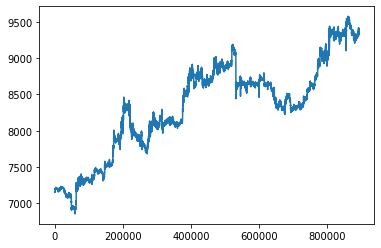

In [38]:
plt.plot(df.close)

## loop

In [36]:
import warnings
warnings.filterwarnings('ignore')
list_symbols = ['ADAM19', 'BCHM19', 'EOSM19', 'ETHM19', 'ETHUSD', 'LTCM19', 'TRXM19', 'XBT7D_D95', 'XBT7D_U105', 'XBTM19', 'XBTU19', 'XBTUSD', 'XRPM19']
symbol = 'ETHUSD'
for timeframe in ['1s','3s','5s','10s']:
    for year in [2019,2020,2021]:
        for month in [1,2,3,4,5,6,7,8,9,10,11,12]:
            try:
                print(f'{datetime.datetime.now()} - dl {year} {month}')
                resample_and_store(symbol, year, month, timeframe)
            except:
                print(f'error dl {year} {month}')

2021-04-09 18:14:08.188126 - dl 2019 1
2021-04-09 18:14:13.957663 - dl 2019 2
2021-04-09 18:14:19.331203 - dl 2019 3
2021-04-09 18:14:25.252251 - dl 2019 4
2021-04-09 18:14:30.927169 - dl 2019 5
2021-04-09 18:14:36.759532 - dl 2019 6
2021-04-09 18:14:42.117164 - dl 2019 7
2021-04-09 18:14:48.043125 - dl 2019 8
2021-04-09 18:14:53.505236 - dl 2019 9
2021-04-09 18:14:58.707213 - dl 2019 10
2021-04-09 18:15:04.102401 - dl 2019 11
2021-04-09 18:15:09.382244 - dl 2019 12
2021-04-09 18:15:14.647758 - dl 2020 1
2021-04-09 18:15:20.091102 - dl 2020 2
2021-04-09 18:15:25.578270 - dl 2020 3
2021-04-09 18:15:31.086634 - dl 2020 4
2021-04-09 18:15:36.488249 - dl 2020 5
2021-04-09 18:15:42.213081 - dl 2020 6
2021-04-09 18:15:47.186506 - dl 2020 7
2021-04-09 18:15:52.492921 - dl 2020 8
2021-04-09 18:15:58.256181 - dl 2020 9
2021-04-09 18:16:03.626451 - dl 2020 10
2021-04-09 18:16:09.304170 - dl 2020 11
2021-04-09 18:16:15.517596 - dl 2020 12
2021-04-09 18:16:21.523144 - dl 2021 1
2021-04-09 18:16:31